# Decision Trees 
from Trevor Stephens (http://trevorstephens.com/)

In Ipython Notebook format by Josue Barnes


Lets load in our training and test data for the titanic.
If you don't already have it, you can download from the Kaggle Machine Learning competition (link below)
https://www.kaggle.com/c/titanic/data

In [165]:
train = read.table("../train.csv", sep =",", header = T)
test = read.table("../test.csv", sep ="," , header = T)

head(train)

Warning message in file(file, "rt"):
“cannot open file '../train.csv': No such file or directory”

ERROR: Error in file(file, "rt"): cannot open the connection


One of the most powerful aspects of R, is how expandable it is. What I mean is that there's hundreds, probably thousands of packages to take on numerous tasks that may not be built into R. Whatever you need to do, there's likely a package for it. 

There's also redundant packages. For example, last week we used party for decision trees, but this week we'll use a package called rpart to do pretty much the same thing. Even though two packages may do the same thing, there are subtle difference that some programmers will prefer. Pick whichever suits your needs.

rpart comes with R, so no need to install, just load the library. However, to make some pretty looking trees, you'll need to install rpart.plot. 

In [ ]:
library(rpart)
install.packages("rpart.plot")
library(rpart.plot)

So last week, yall went over decision trees. But let's do a recap.

Lets's create a decision tree using predictors for survival that you feel are important features. (if you forgot what these features represent check out the Data Dictionary in the Kaggle link in the intro)

What's a decision tree? A set of rules used to partition variables into high purity nodes. Are there any features we should leave out?

In [16]:
head(train, 1)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,,S


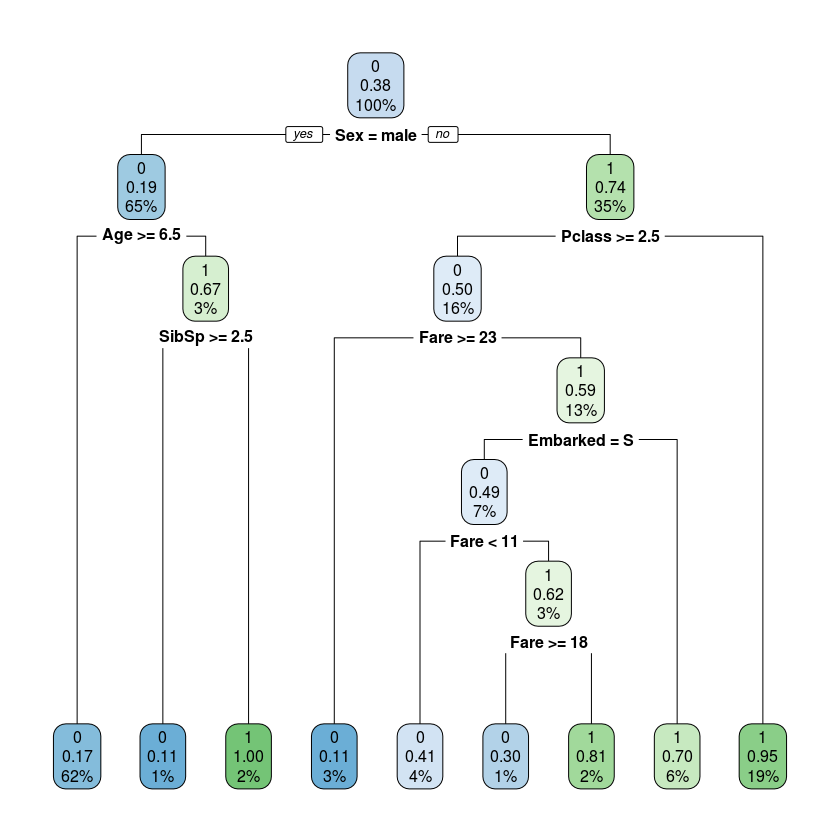

In [135]:
#we can choose which features to use for our prediction by using Survived ~ followed by the feature name
#passengerID, name, ticket, cabin should all be left out for now
fit = rpart(Survived ~ Pclass + Sex + Age + SibSp + Parch + Fare + Embarked, 
             data=train,
             method="class") 

#we have our model, with our features of choice. let's see how the tree is split
rpart.plot(fit)

Let's interpret some of this tree. The top node tells us that we will split on sex. If female, move right. If you were feamle and in a ticket class less than 2.5, you have a 95% chance of survival. This accounts for 19% of cases. This time lets start at the top node and move to the left. If you are a male and over the age of 6.5, you had 17% of survial, and 83% of not surviving accounting ofr 62% of cases. Interesting findings right? But it makes sense that older men forfeit their survival for young boys.

Now, lets use the predict function and apply our new decision tree called "fit" to the test set. Our algorithm has stored all the info and rules from the features we selected previously. As long as our test set has the same features that we to build or algorithm, we should be good to go.

I added a few extra lines of code incase any of you would like to submit your predictions to Kaggle. This is basically creating a dataframe with PassengerID and your prediction of that passengers survial, and then writing it to a csv that you can upload.

In [136]:
#first lets apply our algorithm fit to the test set. 
#Set type to class so that we get 0 and 1 for survival, no and yes respectively
Prediction = predict(fit, test, type = "class")

#SKIP IF NOT ON R
#create data frame of passenger IDs from the test set, and their accompanying predicted survival status from above
submit = data.frame(PassengerId = test$PassengerId, Survived = Prediction)
write.csv(submit, "KaggleDT1.csv", header = T)

rpart has default paramters to make sure that our tree doesn't get overly complex. But what happens if we do allow our tree to become complex? Do we get a better prediction? Let's manipulate some of these parameters to see what happens.

First lets change the 'cp' parameter, this parameters stops unimportant splits from occuring. The other parameter we want to change is 'minsplit' which decides how many cases need to be in a node to carryout a split. 
Let’s max both out: reduce 'cp' to zero (lots of splitting) and 'minsplit' to 2 (only 2 passengers needed for a splitting rule).

Warning message:
“labs do not fit even at cex 0.15, there may be some overplotting”

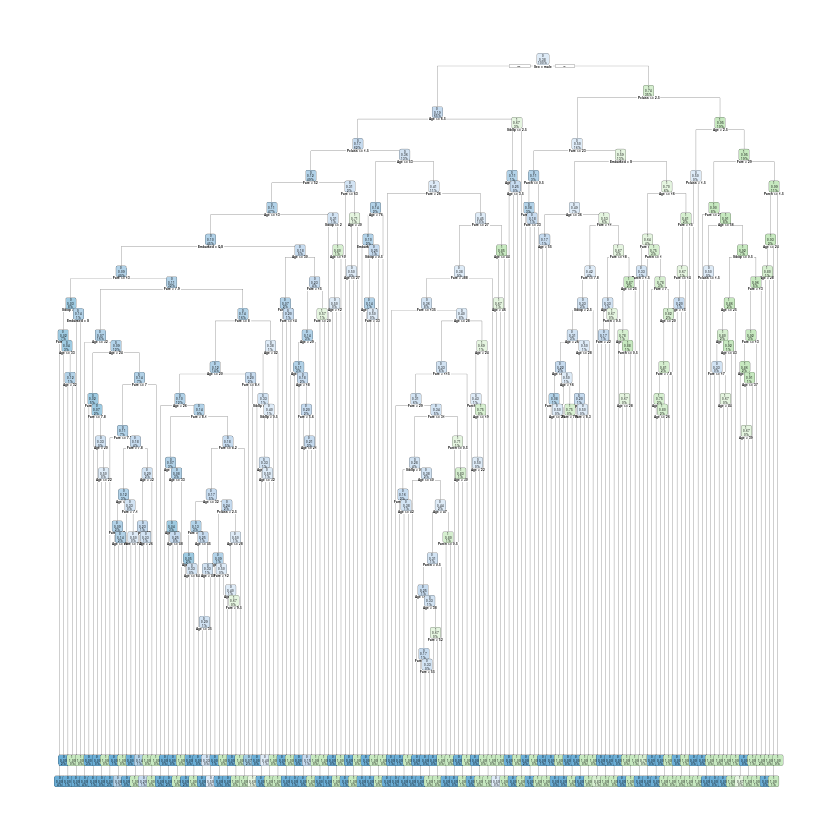

In [63]:
fit2 <- rpart(Survived ~ Pclass + Sex + Age + SibSp + Parch + Fare + Embarked,
               data=train,
               method="class", 
               control=rpart.control(minsplit=2, cp=0)) #this is where we'll make changes

rpart.plot(fit2)

Wow. So, yeah. This isn't even interpretable. But maybe all these specific rules will give us a really good decision tree. 

Let's apply our algorithm to the test set and submit to Kaggle to see if we've improved.

In [ ]:
#can anyone tell me what these few lines of code are doing?
Prediction2 = predict(fit2, test, type = "class")

submit2 = data.frame(PassengerId = test$PassengerId, Survived = Prediction2)
write.csv(submit2, "KaggleDT2.csv")

Sooooo we took a few steps back in our score. Why? Overfitting.

Overfitting is what happens when your algorithm is too complex, and really really good at performing on the training set. Basically, our algorithm learned to recognize almost any case in our training data. Our decsion tree is too well trained on our training set of data creating overgeneralized rules that will likely not help to distingusih survival of unknown indivduals. This results in prediction scores below that of more simple models. 

# Feature Creation
by Trevor Stephens (http://trevorstephens.com/)

Feature creation is an important aspect of machine learners. They will only be as good as the input we give them. Feature creation is going to differ from dataset to dataset, and from problem to problem. But it will always involve extracting bits and pieces of information from what you already have to improve your machine learner. This is why it is so important to really know your data inside and out. The better you know it, the better features you can create. 

Let's first look to the features we didn't use in our decision tree above. The ticket number, cabin, and name were all unique to each passenger but, maybe parts of those text strings could be extracted to build a new predictive attribute. Let’s start with the names.

In [28]:
train$Name[1] #use brackets to index and choose the person in row 1 of train

[1] Braund, Mr. Owen Harris
891 Levels: Abbing, Mr. Anthony ... Zimmerman, Mr. Leo

Its likely that no one had the exact same name, but what part of this name might we see else where? If you guessed the title (i.e. Mr, Mrs, Dr) then you are correct. Maybe this could be a useful feature. 

To make this new feature, we are goning to have to employ some clever R programming to extract just the titles that we are interested. Since we are making a new feature for both the training and test set, we should do it all at once. Let's merge our train and test sets. 

In [35]:
#if we are going to merge the two datasets, we need to make sure they have the same columns
#remember, our test set doesn't have a survived column like our train set
#so lets make a survived column in the test set, full of NA's
test$Survived <- NA

#let's check that are script above worked before merging
head(test)

combi <- rbind(train, test)
#rbind recognizes the column names in each dataframe when merging. 
#If the column names differ, you'll run into a problem

PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,,Q,NA
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,,S,NA
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,,Q,NA
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,,S,NA
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,,S,NA
897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,,S,NA


Let's take a few steps back. When datasets are imported into R, any string of text will be encoded as a factor. Let's check this. We want these to be characters so we can manipulate them easier.

In [64]:
#use the class() function to identify what 'class' of object you're working with. 
class(combi$Name[1])

#even within the same dataframe, different columns will have differing classes of object
class(combi$Fare[1])

[1] "character"

[1] "numeric"

If we want to seperate the text from and indivdual's name and make a new feature, we must convert the object from factor to character by using the function 'as.character'.


In [65]:
#take our new combined dataframe and convert the name column from factor to character
#this will allow us to use different functions to seperate the indivduals name 
combi$Name <- as.character(combi$Name)
combi$Name[1]
class(combi$Name[1])

[1] "Braund, Mr. Owen Harris"

[1] "character"

Now we have just pure character text. In order to break apart a string we need character patterns, or regular expressions, to tell the program to look for so that it can split. 

We see that there is a comma right after the person’s last name, and period after their title. We can use the function strsplit to tell R that we want a person's name split up in a specific way.

In [152]:
#input what you want to split, and how you want to split it

#1
strsplit(combi$Name[1], split='[.]')
#2
strsplit(combi$Name[1], split='[,]')
#3
strsplit(combi$Name[1], split='[,.]')

#which should we use? Remember, we want to get the title by itself

[[1]]
[1] "Braund, Mr"   " Owen Harris"

[[1]]
[1] "Braund"           " Mr. Owen Harris"

c..Braund.....Mr.....Owen.Harris..,Braund,Mr,Owen Harris


If we look at the last example, it is the only one that gets "Mr" by itself. Note that there is a small space before Mr, we'll have to take care of this later.

So our name is split up but how do we get to that title piece by itself and get rid of the first/middle name and last name? You guessed it, indexing! Notice that an index [[1]] is printed before the text portions above. 

strsplit is creating a list, so we want the fist key of that list. We do this by tacking on [[1]] to the end of function.

In [138]:
#lets appennd [[1]] to the end of the function
strsplit(combi$Name[1], split='[,.]')[[1]]

#this works on any indivdual
strsplit(combi$Name[151], split='[,.]')[[1]]
strsplit(combi$Name[23], split='[,.]')[[1]]

[1] "Braund"       " Mr"          " Owen Harris"

[1] "Bateman"       " Rev"          " Robert James"

[1] "McGowan"         " Miss"           " Anna \"Annie\""

Ok so we made some progress, it may not look like much but we are getting closer to isolating the title. We have gone into the first level of our list produced by string split, but now we need to call on the second element of that first level because that is where the title. Let's take a look at this below:

In [139]:
#let's get into the first level of our list, which you can now think of as vector
#then lets call the second element of that vector which should hold our title 
strsplit(combi$Name[1], split='[,.]')[[1]][2]

#again, this work on any indivdual
strsplit(combi$Name[151], split='[,.]')[[1]][2]
strsplit(combi$Name[23], split='[,.]')[[1]][2]

[1] " Mr"

[1] " Rev"

[1] " Miss"

BOOM! We got it. Next challange, how do we extract the title for every person in our dataframe combi? This is a tricky step, there's lot of way this can be done. I'll show you one here.

We will utilize R's 'sapply function'. This is basically a way to tell R to run the same function for a specific set of data, and create a vector of outputs. This can be a built in function, or you can make a function kind of like we did above to extract the title. I'll show you two different ways to go about do this.

In [156]:
#first lets create a function and call it 'get_title'
#the input for our function will be a number, from 1 to however many rows combi is. You can use nrow(combi) to check
#recall that combi$Name[1] gives us the name of the first person, so here we will set that 1 to an x instead
#then let's just copy our code to extract the title

get_title <- function (x) {
    strsplit(combi$Name[x], split='[,.]')[[1]][2]
}

#how does this compare to what we got above? try it out!
get_title(1)
get_title(151)
get_title(23)


#now lets make a new column in combi called Title, and apply our new function using 'sapply'
#essentially what this is saying is "hey R, use numbers 1 thru 1309, nrow(combi), in the function get_title"
#remember, our function get_title is already extracting info from combi$name

combi$Title <- sapply(1:nrow(combi), FUN = get_title)

#lets check our new column out
head(combi)


PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,Surname,FamilyID
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,,S,Mr,2,Braund,Small
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C,Mrs,2,Cumings,Small
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,,S,Miss,1,Heikkinen,Small
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,Mrs,2,Futrelle,Small
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,,S,Mr,1,Allen,Small
6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,,Q,Mr,1,Moran,Small


In [158]:
#another way to do this is, is to put everything in one place. your function and the data you want to use
#this is the same as what we did above, just compressed into one line of code

combi$Title <- sapply(combi$Name, FUN=function(x) {strsplit(x, split='[,.]')[[1]][2]})
head(combi)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,Surname,FamilyID
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,,S,Mr,2,Braund,Small
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C,Mrs,2,Cumings,Small
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,,S,Miss,1,Heikkinen,Small
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,Mrs,2,Futrelle,Small
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,,S,Mr,1,Allen,Small
6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,,Q,Mr,1,Moran,Small


Great, so we have our titles. Now we just need to figure out how to get rid of the space before the titles that I mentioned earlier. A qucik and easy way to do this is using the 'sub' function. Which you guessed it, stands for substitute.

In [160]:
#we want to get rid of the space in any string in the column Title
#sub("what you want to change", "what you want to change it to", what data do you want to use this on)
#just so you have a better idea of whats going on below --> sub("space", "no_space", data)
combi$Title <- sub(' ', '', combi$Title)
table(combi$Title)


       Capt         Col         Don        Dona          Dr    Jonkheer 
          1           4           1           1           8           1 
       Lady       Major      Master        Miss        Mlle         Mme 
          1           2          61         260           2           1 
         Mr         Mrs          Ms         Rev         Sir theCountess 
        757         197           2           8           1           1 

Looking at the table above, we see that same Titles are a bit redundant. So let's try grouping some Titles together, and reduce the number of small categories. For example Mademoiselle and Madame pretty similar. Captain, Colonel, Don, Major, Sir, are similar. So let's look at a few lines of code that search through a dataframe or column, look for a defined string and are then renamed. In this first example, we are searching for "Mme" and "Mlle" in our column Title of combi. Then we convert any instance of "Mme" and "Mlle" into "Mlle". We will do the same for other groups. 

In [164]:
combi$Title[combi$Title %in% c('Mme', 'Mlle')] <- 'Mlle'
combi$Title[combi$Title %in% c('Col','Capt', 'Don', 'Major', 'Sir')] <- 'Sir'
combi$Title[combi$Title %in% c('Dona', 'Lady', 'theCountess', 'Jonkheer')] <- 'Lady'
table(combi$Title)

#Our final step is to change the variable type back to a factor, 
#as these are essentially categories that we have created:
combi$Title <- factor(combi$Title)


         Dr        Lady      Master        Miss        Mlle          Mr 
          8           4          61         260           3         757 
        Mrs          Ms         Rev         Sir theCountess 
        197           2           8           9           0 

Alright. We’re done with the passenger’s title now. What else can we think up?

Once we are done creating features we need to undo the merging of our data frame and get rid of the survived column in the test set that are full of NAs

In [57]:
train <- combi[1:891,]
test <- combi[892:1309,-c("Survived")]

Let's see how are new feature changes are decision tree from the one we used earlier in this lesson.

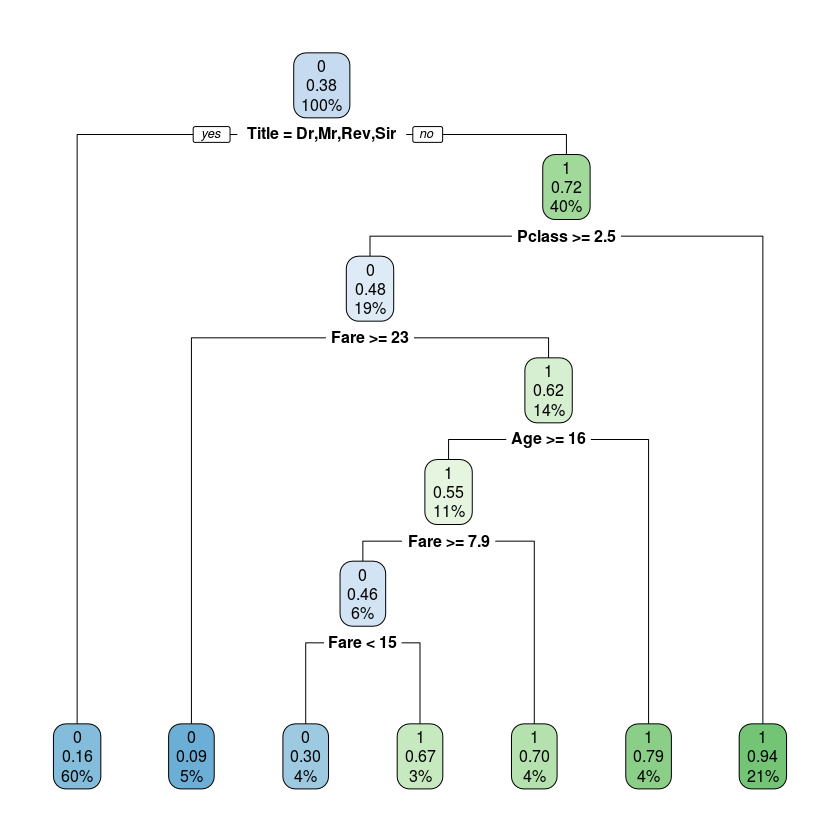

In [89]:
fit <- rpart(Survived ~ Pclass + Sex + Age + SibSp + Parch + Fare + Embarked + Title,
               data=train, 
               method="class")

rpart.plot(fit)

Prediction <- predict(fit, test, type = "class")

submit <- data.frame(PassengerId = test$PassengerId, Survived = Prediction)

What's the difference in these?